In [1]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
%load_ext tensorboard
import os
import sys
import cv2
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from google.colab.patches import cv2_imshow
import sklearn
from sklearn import model_selection
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import copy
import time

import segmentation_models_pytorch

import albumentations as A
#from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
os.makedirs("/content/VAI/Train/Labeled/Flooded/image", exist_ok=True)
os.makedirs("/content/VAI/Train/Labeled/Non-Flooded/image", exist_ok=True)
os.makedirs("/content/VAI/Train/Labeled/Flooded/mask", exist_ok=True)
os.makedirs("/content/VAI/Train/Labeled/Non-Flooded/mask", exist_ok=True)
os.makedirs("/content/VAI/Train/Unlabeled/image", exist_ok=True)
os.makedirs("/content/VAI/Test/image", exist_ok=True)

In [9]:
# !ls /content/drive/MyDrive/FloodNet\ Challenge\ @\ EARTHVISION\ 2021\ -\ Track\ 1/Train/Labeled

!ls "/content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Labeled"

Flooded  Non-Flooded


In [10]:

!ls "/content/VAI/Train/Labeled/Flooded"

image  mask


In [2]:
RESIZE=(256,256)
temp_root = "/content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1"
local_root = "/content/VAI"
import cv2
import os
from tqdm import tqdm

# Your resize and save function
def resize_and_save(path, resize=(256, 256), samples=None):
    # Assuming temp_root and local_root are defined elsewhere in your code
    for img_name in tqdm(os.listdir(os.path.join(temp_root, path))[:samples]):
        img_path = os.path.join(temp_root, path, img_name)

        # Check if the file exists
        if os.path.exists(img_path):
            # Read the image
            img = cv2.imread(img_path)

            # Check if image is successfully loaded
            if img is not None:
                # Resize the image
                img_resized = cv2.resize(img, resize)

                # Save the resized image
                save_path = os.path.join(local_root, path, img_name)
                cv2.imwrite(save_path, img_resized)
            else:
                print(f"Error reading image: {img_path}")
        else:
            print(f"File does not exist: {img_path}")


In [12]:
resize_and_save("Train/Labeled/Flooded/image")
resize_and_save("Train/Labeled/Non-Flooded/image")
resize_and_save("Train/Labeled/Flooded/mask")
resize_and_save("Train/Labeled/Non-Flooded/mask")
resize_and_save("Train/Unlabeled/image")
resize_and_save("Test/image")
resize_and_save("Train/Unlabeled/image", samples=100)

100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


In [12]:
flood_dir = "Train/Labeled/Flooded"
non_flood_dir = "Train/Labeled/Non-Flooded"

f_img_dir = os.path.join(local_root, flood_dir, "image")
f_mask_dir = os.path.join(local_root, flood_dir, "mask")
n_img_dir = os.path.join(local_root, non_flood_dir, "image")
n_mask_dir = os.path.join(local_root, non_flood_dir, "mask")

f_img = len(os.listdir(f_img_dir))
f_mask = len(os.listdir(f_mask_dir))
n_img = len(os.listdir(n_img_dir))
n_mask = len(os.listdir(n_mask_dir))
print(f"Flooded images:      {f_img} Flooded masks:     {f_mask}")
print(f"Non-Flooded images: {n_img} Non-Flooded masks: {n_mask}")

Flooded images:      51 Flooded masks:     51
Non-Flooded images: 347 Non-Flooded masks: 347


In [4]:
CLASSES={'Background':0,'Building-flooded':1,'Building-non-flooded':2,'Road-flooded':3,'Road-non-flooded':4,
         'Water':5,'Tree':6,'Vehicle':7,'Pool':8,'Grass':9}
IMG_DIM= 512

In [5]:
TENSORBOARD_DIR = "/content/drive/MyDrive/runs_h/"
MODEL_DIR = "/content/drive/MyDrive/models_h/"
UNLABELLED_SPLIT = 100

os.makedirs(TENSORBOARD_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

ENCODER_DEPTH=5
DECODER_CHANNELS=256
BATCH_SIZE= [2]
EPOCHS= 100
LR = [1e-3]
ENCODER_NAME= 'efficientnet-b3'

In [13]:
dirs = """
flood_dir
non_flood_dir

f_img_dir
f_mask_dir
n_img_dir
n_mask_dir
"""
x_f = [os.path.join(f_img_dir, file) for file in sorted(os.listdir(f_img_dir))]
x_n = [os.path.join(n_img_dir, file) for file in sorted(os.listdir(n_img_dir))]

x = x_f + x_n

x_train, x_test = model_selection.train_test_split(x, test_size=0.3, shuffle=True)

train_transform1 = A.Compose([
        A.Resize(IMG_DIM, IMG_DIM),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

train_transform2=A.Compose([ToTensorV2()])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [41]:
class SegDataset:
    def __init__(self, x_paths, trans1, trans2, img_dim, unlabelled=False):
        self.x_paths = x_paths
        self.unlabelled = unlabelled
        if not self.unlabelled:
            self.y_paths = [x.replace("image", "mask").replace(".jpg", "_lab.png") for x in self.x_paths]
        else:
            self.y_paths = None
        self.img_dim = img_dim
        self.trans1 = trans1
        self.trans2 = trans2

    def __len__(self):
        return len(self.x_paths)

    def get_newMask(self, mask, classes, dim=IMG_DIM):
      if mask.ndim == 3:
          mask = torch.as_tensor(mask[:, :, 0], dtype=torch.int64)
      elif mask.ndim == 2:
          mask = torch.as_tensor(mask, dtype=torch.int64)

      # Convert to one-hot format: (H, W, num_classes) -> (num_classes, H, W)
      mask = torch.nn.functional.one_hot(mask, num_classes=len(classes)).permute(2, 0, 1).float()

      return mask



    def __getitem__(self, index):
    # Read and convert image
      image = cv2.imread(self.x_paths[index])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Preprocess the image
      kernel = np.ones((2, 2), np.uint8)
      image = cv2.bilateralFilter(image, 5, 75, 75)
      image = cv2.erode(cv2.dilate(image, kernel, iterations=2), kernel, iterations=1)

      # Read mask (if not unlabelled)
      if not self.unlabelled:
          mask = cv2.imread(self.y_paths[index], cv2.IMREAD_GRAYSCALE)
      else:
          mask = np.zeros((512, 512), dtype=np.uint8)  # Dummy all-zero mask

      # Apply transformations
      if self.trans1:
          transformed1 = self.trans1(image=image, mask=mask)
          image, mask = transformed1["image"], transformed1["mask"]

      if self.trans2:
          transformed2 = self.trans2(image=image, mask=mask)
          image, mask = transformed2["image"], transformed2["mask"]

      # Convert mask to tensor
      mask = torch.as_tensor(mask, dtype=torch.int64)

      # Convert mask to one-hot encoding (for BCEWithLogitsLoss)
      mask = torch.nn.functional.one_hot(mask, num_classes=10).permute(2, 0, 1).float()

      return image, mask




In [7]:
def dice_loss(pred, target, smooth = 1e-5):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

In [8]:
def calc_loss(pred, target, metrics, bce_weight=0.5, unlabelled=False):
    bce = F.binary_cross_entropy_with_logits(pred, target.to(torch.float32))
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    target_np=target.data.cpu().numpy()
    pred_np=pred.data.cpu().numpy()
    MIoU= np.mean(sklearn.metrics.jaccard_score(np.argmax(target_np,axis=1).flatten(), np.argmax(pred_np,axis=1).flatten(), average=None))
    loss = bce * bce_weight + dice * (1 - bce_weight)
    if not unlabelled:
      metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
      metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
      metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
      metrics['MIoU'] += MIoU * target.size(0)

    return loss

In [9]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

In [42]:
training_set = SegDataset(x_train,  train_transform1, train_transform2, img_dim=IMG_DIM)
testing_set = SegDataset(x_test, train_transform1,train_transform2, img_dim=IMG_DIM)
image_datasets = {'train': training_set, 'valid': testing_set}

u_dir = "/content/new/Train/Unlabeled/image"
unlabelled_paths = [os.path.join(u_dir, file) for file in os.listdir(u_dir)]
unlabelled_set = SegDataset(unlabelled_paths[0:-500], trans1=train_transform1,trans2=train_transform2, img_dim=IMG_DIM, unlabelled=True)
image_datasets["unlabelled"] = unlabelled_set

In [15]:
from torchvision import models
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, len(CLASSES), kernel_size=(1, 1), stride=(1, 1))  # Adjust the output channels to the number of classes
model.to(device)

# Setup optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=LR[0])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
def train_model(model, image_datasets, optimizer, scheduler, num_epochs=EPOCHS):
    best_model_wts = model.state_dict()
    best_miou = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Ensure dataset for each phase is non-empty before training
        for phase in ['train', 'valid', 'unlabelled']:
            dataset_length = len(image_datasets[phase])
            if dataset_length == 0:
                print(f"Warning: {phase} dataset is empty. Skipping this phase.")
                continue

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            metrics = {'bce': 0.0, 'dice': 0.0, 'loss': 0.0, 'MIoU': 0.0}
            epoch_samples = 0

            for inputs, labels in tqdm(DataLoader(image_datasets[phase], batch_size=BATCH_SIZE[0], shuffle=True, num_workers=4)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)['out']
                    loss = calc_loss(outputs, labels, metrics)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)

            if phase == 'valid' or phase == 'unlabelled':
                miou = metrics['MIoU'] / epoch_samples
                if miou > best_miou:
                    best_miou = miou
                    best_model_wts = model.state_dict()

            if phase == 'train':
                # Step scheduler only for training phase
                scheduler.step()

        print(f"End of epoch {epoch}. Best MIoU so far: {best_miou:.4f}")
        print()

    model.load_state_dict(best_model_wts)
    return model


In [49]:
model = train_model(model, image_datasets, optimizer, scheduler, num_epochs=EPOCHS)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0/99
----------


100%|██████████| 139/139 [02:35<00:00,  1.12s/it]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train: bce: 0.186042, dice: 0.860666, loss: 0.523354, MIoU: 0.176895


100%|██████████| 60/60 [00:27<00:00,  2.16it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid: bce: 0.498701, dice: 0.876946, loss: 0.687823, MIoU: 0.140724
End of epoch 0. Best MIoU so far: 0.1407

Epoch 1/99
----------


100%|██████████| 139/139 [02:36<00:00,  1.13s/it]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train: bce: 0.179085, dice: 0.855435, loss: 0.517260, MIoU: 0.191425


100%|██████████| 60/60 [00:27<00:00,  2.16it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid: bce: 0.350396, dice: 0.875046, loss: 0.612721, MIoU: 0.152809
End of epoch 1. Best MIoU so far: 0.1528

Epoch 2/99
----------


100%|██████████| 139/139 [02:35<00:00,  1.12s/it]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train: bce: 0.174820, dice: 0.849706, loss: 0.512263, MIoU: 0.197428


100%|██████████| 60/60 [00:27<00:00,  2.19it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid: bce: 0.688597, dice: 0.865872, loss: 0.777235, MIoU: 0.152175
End of epoch 2. Best MIoU so far: 0.1528

Epoch 3/99
----------


100%|██████████| 139/139 [02:36<00:00,  1.13s/it]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train: bce: 0.170841, dice: 0.844412, loss: 0.507627, MIoU: 0.199399


100%|██████████| 60/60 [00:27<00:00,  2.21it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid: bce: 4.145886, dice: 0.851597, loss: 2.498742, MIoU: 0.137592
End of epoch 3. Best MIoU so far: 0.1528

Epoch 4/99
----------


 47%|████▋     | 65/139 [01:14<01:24,  1.15s/it]


KeyboardInterrupt: 

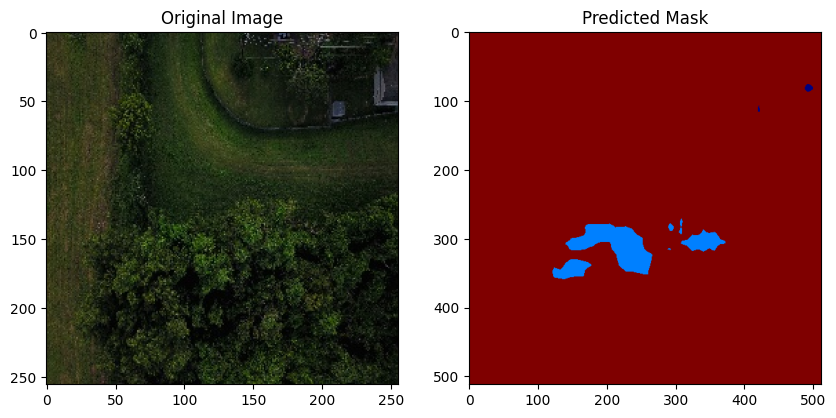

In [64]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the transformation
transform = A.Compose([
    A.Resize(512, 512),  # Resize to match training size
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize if applied in training
    ToTensorV2()  # Convert to PyTorch tensor
])

def predict_single_image(model, image_path, device):
    model.eval()  # Set model to evaluation mode

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Apply transformations
    transformed = transform(image=image)
    input_tensor = transformed["image"].unsqueeze(0).to(device)  # Add batch dimension

    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)['out']

        # Convert the model's output (multi-class) to a predicted class mask
        pred_mask = torch.argmax(output, dim=1)  # Get class with highest score for each pixel

    # Convert to numpy
    pred_mask = pred_mask.squeeze().cpu().numpy()

    # Plot original image and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='jet')  # Use 'jet' colormap for better multi-class visualization
    plt.title("Predicted Mask")
    plt.show()

# Example usage
predict_single_image(model, "/content/VAI/Test/image/6850.jpg", device)
